# Notebook 01 — Persistence Baseline (Hour-ahead)

## Why persistence?
Persistence forecasting assumes that the next-hour irradiance equals the current-hour irradiance:

ŷ(t+1) = y(t)

This is the minimum benchmark for short-term solar forecasting. Many complex models fail
to beat persistence consistently, especially in highly variable weather regimes.

## Why this is a valid baseline for grid operations
In hour-ahead operations, control rooms often rely on “what is happening now” as the
default expectation for the next scheduling interval. Persistence provides a defensible
reference point: any model that cannot outperform it does not justify operational use.

### 1) Data loading
Note: The raw NASA export is LST (Land Surface Temperature). For Phase 1, treating it as UTC is acceptable as long as we are consistent. In Phase 2, correct timezone conversion will be handled. In this notebook we obey the spec: “set timezone explicitly (UTC)”.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data/Dataset_phase_1_clean.csv")
df["time"] = pd.to_datetime(df["time"], utc=True)  # set timezone explicitly (UTC)

df = df.sort_values("time")
df.head()

,time,ghi_wh_m2,temp_c
0,2021-01-01 00:00:00+00:00,0.0,23.35
1,2021-01-01 01:00:00+00:00,0.0,22.70
2,2021-01-01 02:00:00+00:00,0.0,22.03
3,2021-01-01 03:00:00+00:00,0.0,21.40
4,2021-01-01 04:00:00+00:00,0.0,20.78


### 2) Basic sanity checks

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43056 entries, 0 to 43055
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   time       43056 non-null  datetime64[ns, UTC]
 1   ghi_wh_m2  43056 non-null  float64            
 2   temp_c     43056 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 1009.3 KB


,ghi_wh_m2,temp_c
count,43056.000000,43056.000000
mean,245.349914,28.371682
std,327.459773,5.924298
min,0.000000,12.460000
25%,0.000000,23.977500
50%,6.585000,27.590000
75%,499.945000,32.500000
max,1095.900000,45.420000


### 3) Basic EDA: plot 1–2 weeks (1st two weeks)

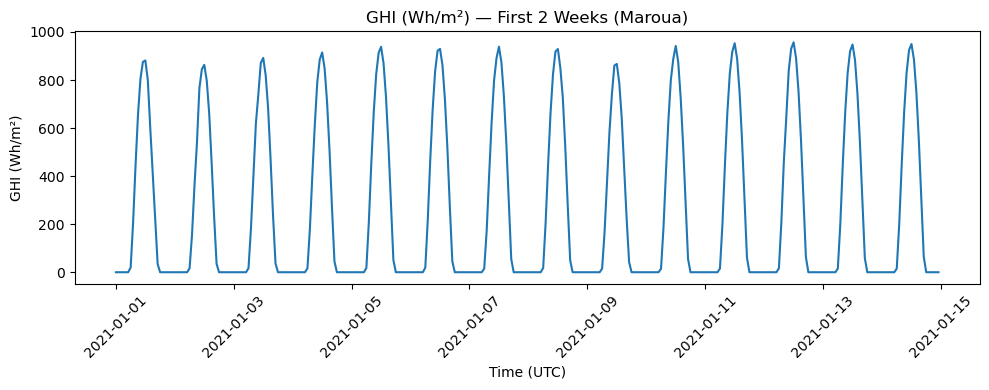

In [2]:
import matplotlib.pyplot as plt

df_2w = df[(df["time"] >= "2021-01-01") & (df["time"] < "2021-01-15")]

plt.figure(figsize=(10, 4))
plt.plot(df_2w["time"], df_2w["ghi_wh_m2"])

plt.xticks(rotation=45)

plt.title("GHI (Wh/m²) — First 2 Weeks (Maroua)")
plt.xlabel("Time (UTC)")
plt.ylabel("GHI (Wh/m²)")

plt.tight_layout()
plt.show()

### 4) Seasonal profile (monthly mean)

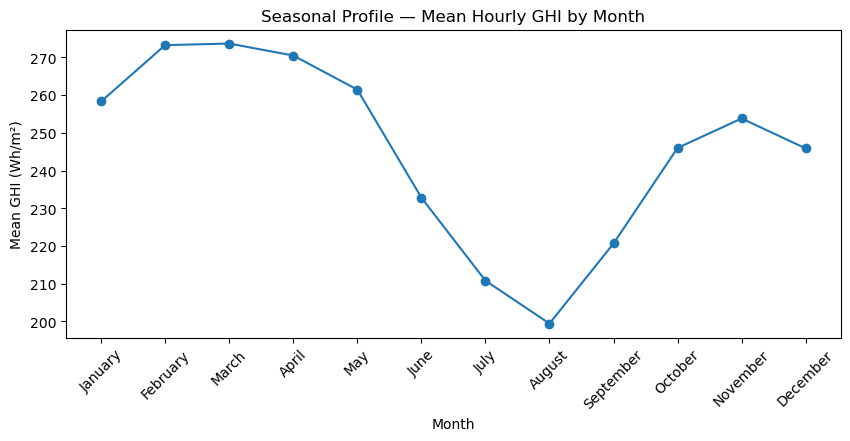

In [25]:
import calendar

df["month"] = df["time"].dt.month
monthly = df.groupby("month")["ghi_wh_m2"].mean()

plt.figure(figsize=(10, 4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Seasonal Profile — Mean Hourly GHI by Month")
plt.xlabel("Month")
plt.ylabel("Mean GHI (Wh/m²)")
plt.xticks(ticks=range(1,13), labels=[calendar.month_name[i] for i in range(1, 13)])
plt.xticks(rotation=45)
plt.show()

### 5) Identify night values (zero irradiance)

In [26]:
zero_pct = (df["ghi_wh_m2"] == 0).mean() * 100
print(f"Percentage of zero irradiance (night hours): {zero_pct:.2f}%")

df[df["ghi_wh_m2"] == 0].head()

Percentage of zero irradiance (night hours): 49.04%


,time,ghi_wh_m2,temp_c,month
0,2021-01-01 00:00:00+00:00,0.0,23.35,1
1,2021-01-01 01:00:00+00:00,0.0,22.70,1
2,2021-01-01 02:00:00+00:00,0.0,22.03,1
3,2021-01-01 03:00:00+00:00,0.0,21.40,1
4,2021-01-01 04:00:00+00:00,0.0,20.78,1


### 6) Train/test split (time-based)
Train/test split (time-based)

In [28]:
train = df[df["time"] < "2025-01-01"].copy()
test = df[df["time"] >= "2025-01-01"].copy()

print("Train rows:", len(train))
print("Test rows:", len(test))

Train rows: 35064
Test rows: 7992


### 7) Persistence logic (t+1 = t)
Shift carefully and handle boundaries explicitly:

In [29]:
test["y_true"] = test["ghi_wh_m2"]
test["y_pred"] = test["ghi_wh_m2"].shift(1)

# Boundary: first row has no previous value -> drop
test_eval = test.dropna(subset=["y_pred"]).copy()

test_eval.head()

,time,ghi_wh_m2,temp_c,month,y_true,y_pred
35065,2025-01-01 01:00:00+00:00,0.0,19.19,1,0.0,0.0
35066,2025-01-01 02:00:00+00:00,0.0,18.34,1,0.0,0.0
35067,2025-01-01 03:00:00+00:00,0.0,17.54,1,0.0,0.0
35068,2025-01-01 04:00:00+00:00,0.0,16.76,1,0.0,0.0
35069,2025-01-01 05:00:00+00:00,0.0,15.98,1,0.0,0.0


### 8) Evaluation (RMSE, MAE, MAPE)
Use sklearn metrics as specified:

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test_eval["y_true"].values
y_pred = test_eval["y_pred"].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# MAPE caveat: misleading near zero. Mask low irradiance hours.
mask = y_true > 50
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Persistence Baseline — Test Year 2025")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE (GHI>50 Wh/m²):", mape)

Persistence Baseline — Test Year 2025
RMSE: 115.11471692798487
MAE : 74.71966211988487
MAPE (GHI>50 Wh/m²): 52.291658544020535


- MAE (Mean Absolute Error): This is the average of all individual errors. If your MAE is 50, it means that on average, your persistence forecast is off by 50 Wh/m2. It treats all errors equally.
- RMSE (Root Mean Squared Error): This squares the errors before averaging them, then takes the square root. Because it squares the errors, RMSE penalizes large outliers more heavily than MAE. If you have a few days where the forecast was "way off" (like a sudden storm), the RMSE will jump significantly higher than the MAE.

- MAPE (Mean Absolute Percentage Error): This expresses the error as a percentage. (mask): y_true > 50 creates a filter that only looks at times when the sun is actually up and providing significant energy.

#### Ideal values for the various matrix usorted
| Metric | Ideal Value | What it tells you |
| :--- | :--- | :--- |
| **MAE** | 0 | The average "miss" in units of $Wh/m^2$. |
| **RMSE** | 0 | How much you should worry about "big misses" (outliers). |
| **MAPE** | 0% | The average relative error during daylight hours. |

### 9) Why this matters for grid operations
Solar PV variability directly affects **net load** (Demand − Solar). Forecast errors therefore translate into balancing actions that must be handled in real time by flexible generation, storage, or reserves.

**Ramping:**  how fast the net load changes.
- If solar output drops faster than forecasted, the grid must ramp other generators up quickly. Large forecast misses increase ramp stress and can challenge frequency stability, especially in weak or low-flexibility systems.
  
**Reserve Planning:**  Reserves are backup capacity held to cover uncertainty
- Forecast uncertainty determines how much upward and downward reserve must be scheduled ahead of time. Higher forecast error implies higher reserve procurement, which increases operational costs and reduces efficiency.
  
**Operational Risk:**  
- A model with good average performance may still produce occasional large errors. These tail events are critical because they can exhaust reserves and trigger emergency actions. RMSE is therefore interpreted as a proxy for large-error risk, while MAE reflects typical operator exposure.

Forecast accuracy is evaluated here in terms of operational reliability, not purely statistical performance.